# **Computational Tools - Final Project**

In [2]:
import pandas as pd
data = pd.read_csv("../data/fake reviews dataset.csv")
data.head()

category  rating label  \
0  Home_and_Kitchen_5       5    CG   
1  Home_and_Kitchen_5       5    CG   
2  Home_and_Kitchen_5       5    CG   
3  Home_and_Kitchen_5       1    CG   
4  Home_and_Kitchen_5       5    CG   

                                               text_  
0  Love this!  Well made, sturdy, and very comfor...  
1  love it, a great upgrade from the original.  I...  
2  This pillow saved my back. I love the look and...  
3  Missing information on how to use it, but it i...  
4  Very nice set. Good quality. We have had the s...

In [3]:
data.describe()

rating
count  40432.000000
mean       4.256579
std        1.144354
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000

In [4]:
data.duplicated().sum()

12

In [5]:
data.drop_duplicates()

category  rating label  \
0                Home_and_Kitchen_5       5    CG   
1                Home_and_Kitchen_5       5    CG   
2                Home_and_Kitchen_5       5    CG   
3                Home_and_Kitchen_5       1    CG   
4                Home_and_Kitchen_5       5    CG   
...                             ...     ...   ...   
40427  Clothing_Shoes_and_Jewelry_5       4    OR   
40428  Clothing_Shoes_and_Jewelry_5       5    CG   
40429  Clothing_Shoes_and_Jewelry_5       2    OR   
40430  Clothing_Shoes_and_Jewelry_5       1    CG   
40431  Clothing_Shoes_and_Jewelry_5       5    OR   

                                                   text_  
0      Love this!  Well made, sturdy, and very comfor...  
1      love it, a great upgrade from the original.  I...  
2      This pillow saved my back. I love the look and...  
3      Missing information on how to use it, but it i...  
4      Very nice set. Good quality. We have had the s...  
...                                                  ...  
40427  I had read some reviews saying that this bra r...  
40428  I wasn't sure exactly what it would be. It is ...  
40429  You can wear the hood by itself, wear it with ...  
40430  I liked nothing about this dress. The only rea...  
40431  I work in the wedding industry and have to wor...  

[40420 rows x 4 columns]

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.decomposition import PCA
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [7]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joninamatt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joninamatt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
data = pd.read_csv("../data/fake reviews dataset.csv")
texts = data['text_']
true_labels = data['label'].map({'CG': 0, 'OR': 1})  # Convert labels to binary


In [9]:
# Feature extraction
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(data['text_'])

# Dimensionality reduction (optional)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X.toarray())

# k-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

# Evaluate clusters
accuracy = accuracy_score(true_labels, clusters)

print(f'Accuracy: {accuracy}')


Accuracy: 0.5193658488326078


# **Locality Sensitivity Hashing**

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from datasketch import MinHash, MinHashLSH
import json

# Load the preprocessed dataset
# Load the CSV
df = pd.read_csv('../data/processed_dataFINAL.csv')

# Convert JSON strings back to Python lists
df['processed_text'] = df['processed_text'].apply(json.loads)

# Ensure 'processed_text' is a string
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Do label_binary based on label
df['label_binary'] = df['label'].apply(lambda x: 1 if x == 'CG' else 0)

# Vectorize text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

# Create MinHash for each review
def create_minhash(text):
    m = MinHash(num_perm=128)
    for word in text.split():
        m.update(word.encode('utf8'))
    return m

df['minhash'] = df['processed_text'].apply(create_minhash)

# Create LSH index
lsh = MinHashLSH(threshold=0.5, num_perm=128)
for i, m in enumerate(df['minhash']):
    lsh.insert(str(i), m)

# Assign predicted label based on nearest neighbors in LSH index
def predict_label_using_lsh(index):
    similar_items = lsh.query(df['minhash'][index])
    
    # Count the number of 'CG' vs 'OR' labels in similar reviews
    similar_labels = df.iloc[[int(i) for i in similar_items]]['label_binary']
    predicted_label = similar_labels.mode()[0]  # Take the most common label in the similar items
    return predicted_label

# Apply LSH-based prediction to the entire dataset
df['predicted_label'] = df.index.map(predict_label_using_lsh)

# Evaluate performance
accuracy = accuracy_score(df['label_binary'], df['predicted_label'])
classification_rep = classification_report(df['label_binary'], df['predicted_label'])

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")


Accuracy: 0.9510288880094975
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     20216
           1       0.94      0.96      0.95     20216

    accuracy                           0.95     40432
   macro avg       0.95      0.95      0.95     40432
weighted avg       0.95      0.95      0.95     40432



### **Wordcloud**

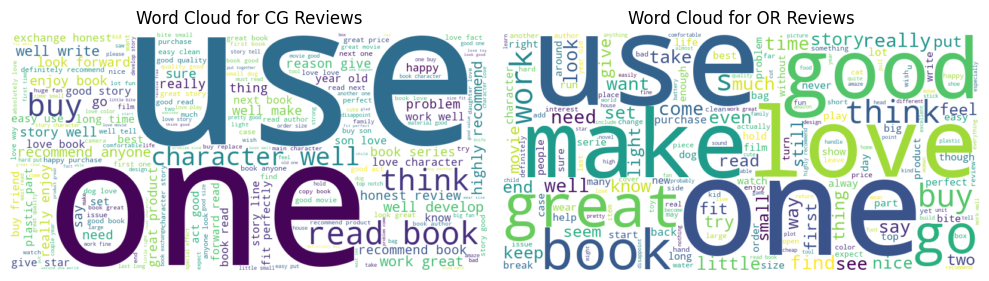

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate data for CG and OR
df_cg = df[df['label_binary'] == 1]  # Computer Generated reviews
df_or = df[df['label_binary'] == 0]  # Original reviews

# Create WordCloud for CG reviews
wordcloud_cg = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_cg['processed_text']))

# Create WordCloud for OR reviews
wordcloud_or = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_or['processed_text']))

# Display the Word Clouds for CG and OR
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_cg, interpolation='bilinear')
plt.title("Word Cloud for CG Reviews")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_or, interpolation='bilinear')
plt.title("Word Cloud for OR Reviews")
plt.axis('off')

plt.tight_layout()
plt.show()


<Figure size 2000x2000 with 0 Axes>

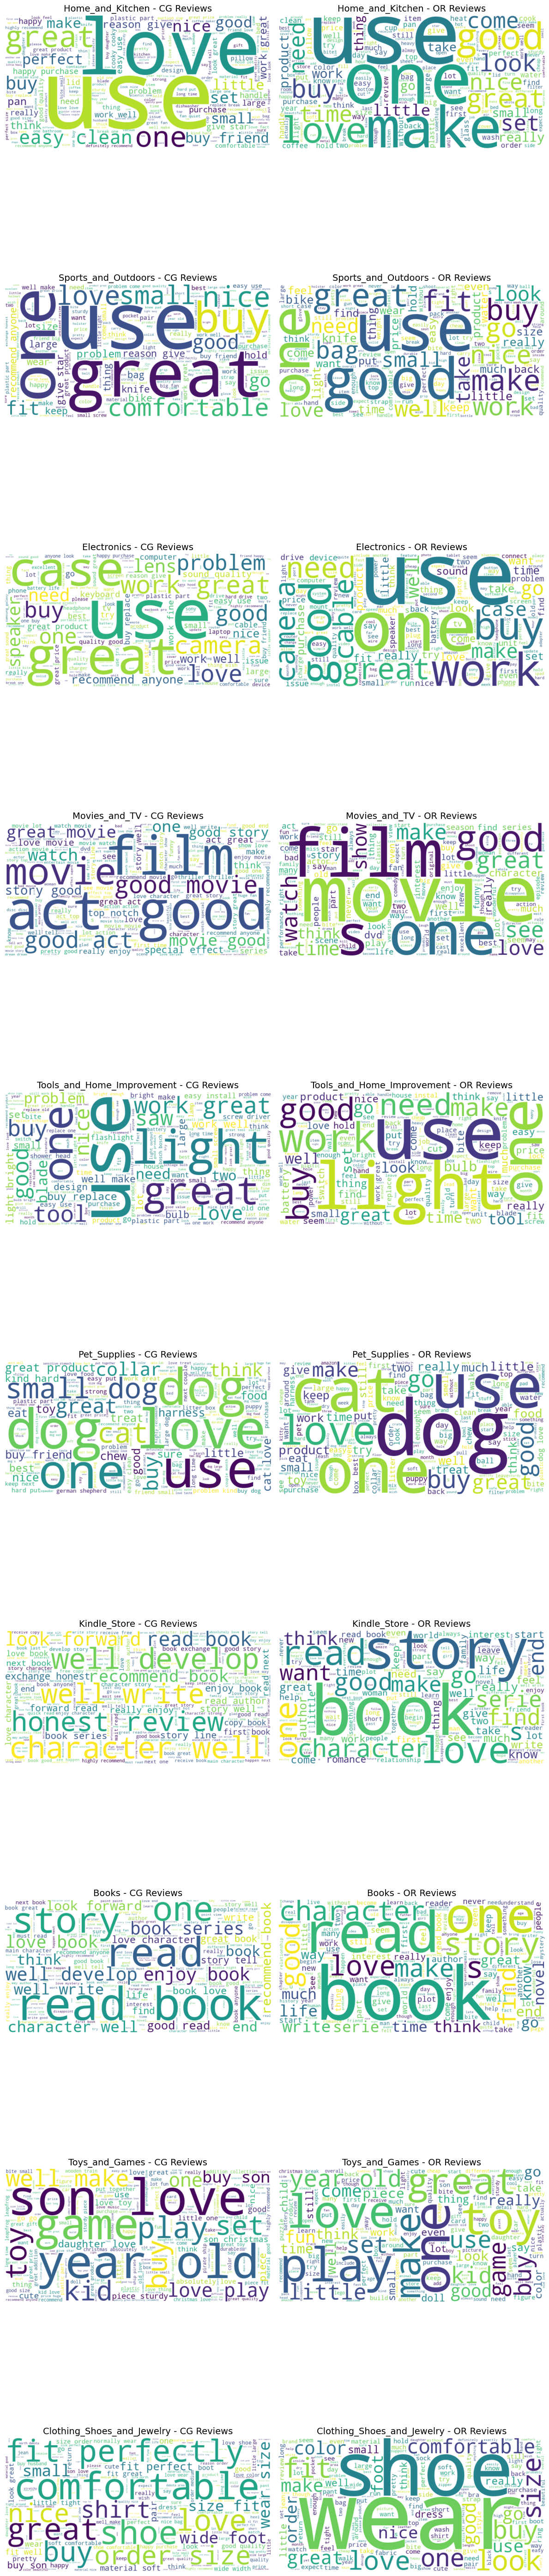

In [28]:
# Set up the plot
plt.figure(figsize=(20, 20))

# Get unique categories
categories = df['category'].unique()

# Set up the plot with a larger figure size
fig, axes = plt.subplots(len(categories), 2, figsize=(12, len(categories)*6))  # Increase figure height

# Loop through categories and create word clouds for CG and OR
for i, category in enumerate(categories):
    # Filter data for this category
    category_data = df[df['category'] == category]

    # Separate data for CG and OR within the category
    df_cg_category = category_data[category_data['label_binary'] == 1]  # Computer Generated reviews
    df_or_category = category_data[category_data['label_binary'] == 0]  # Original reviews
    
    # Create WordCloud for CG reviews in this category
    wordcloud_cg = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_cg_category['processed_text']))
    
    # Create WordCloud for OR reviews in this category
    wordcloud_or = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_or_category['processed_text']))
    
    # Plot the word clouds for CG and OR side by side for this category
    axes[i, 0].imshow(wordcloud_cg, interpolation='bilinear')
    axes[i, 0].set_title(f'{category} - CG Reviews', fontsize=14)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(wordcloud_or, interpolation='bilinear')
    axes[i, 1].set_title(f'{category} - OR Reviews', fontsize=14)
    axes[i, 1].axis('off')

# Adjust layout and spacing
plt.tight_layout()
plt.show()